## Section501_Group10_FinalProjectB

##### Question 5
- a. maFast = 20
- b. maSlow = 240
- c. bbWindow = 15
- d. bbStdevBand = 2
- e. (in alphabetical order) myStrategies = ['AAPL-BMK-MA', 'AMZN-BMK-MA', 'ATT-BB', 'AUD-MAFlat', 'FBNDX-MAFlat', 'GOLD-MAShort', 'GE-MAShort','SPY-MAShort']

### Question 1:

In [22]:
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

#pd.set_option('display.float_format', '{:.2f}'.format)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Path to the uploaded CSV file
csv_file_path = "PricesProjectB.csv"

# Load the CSV data into a DataFrame
price_data = pd.read_csv(csv_file_path)

# Display the first few rows of the price data to understand its structure
price_data.head()

,Unnamed: 0,AAPL,AMZN,ATT,AUD,EUR,FBNDX,GE,GOLD,INTC,LEHM,SILVER,SPY
0,1999-12-31,0.92,3.81,36.82,0.66,1.01,6.89,396.79,288.00,41.16,798.15,5.38,146.88
1,2000-01-03,1.00,4.47,35.50,0.66,1.02,6.85,384.62,289.00,43.50,793.87,5.41,145.44
2,2000-01-04,0.92,4.10,33.42,0.66,1.03,6.87,369.23,282.25,41.47,796.76,5.33,139.75
3,2000-01-05,0.93,3.49,33.94,0.66,1.03,6.84,368.59,280.00,41.81,793.12,5.14,140.00
4,2000-01-06,0.85,3.28,33.04,0.65,1.03,6.86,373.52,281.10,39.38,795.09,5.12,137.75


### Question 3

In [23]:
#Re-running Part A code for the full period from 12/31/1999 through 10/31/2022

def movingAverageCrossover(price_data, fast_window, slow_window):
    price_data = price_data.copy()  # Create a copy to avoid SettingWithCopyWarning

    if len(price_data.columns) > 1:
        raise ValueError('Only 1 column as input required')

    asset_name = price_data.columns[0].split('-')[0]

    # Calculate fast and slow moving averages
    price_data['Slow_MA'] = price_data.iloc[:, 0].rolling(slow_window).mean()
    price_data['Fast_MA'] = price_data.iloc[:, 0].rolling(fast_window).mean()

    # Remove NaN values
    price_data.dropna(inplace=True)

    # Generate signals for both MAFlat and MAShort strategies
    price_data['Signal_MAFlat'] = np.where(price_data['Fast_MA'] > price_data['Slow_MA'], 1, 0)
    price_data['Signal_MAShort'] = np.where(price_data['Fast_MA'] > price_data['Slow_MA'], 1, -1)

    # Calculate benchmark and strategy returns
    price_data['Benchmark_Returns'] = np.log(price_data.iloc[:, 0] / price_data.iloc[:, 0].shift(1))
    price_data['Strategy_Returns_MAFlat'] = price_data['Signal_MAFlat'].shift(1) * price_data['Benchmark_Returns']
    price_data['Strategy_Returns_MAShort'] = price_data['Signal_MAShort'].shift(1) * price_data['Benchmark_Returns']

    # Drop temporary columns
    price_data = price_data.drop([asset_name, 'Slow_MA', 'Fast_MA', 'Signal_MAFlat', 'Signal_MAShort'], axis=1)

    # Rename columns with asset name and strategy names
    price_data.columns = [
        f'{asset_name}-BMK', 
        f'{asset_name}-MAFlat', 
        f'{asset_name}-MAShort'
    ]
    
    price_data.dropna(inplace=True)

    return price_data

def bollingerBands(price_data, lookback_window, std_dev_band):
    price_data = price_data.copy()  # Create a copy to avoid SettingWithCopyWarning
    
    if len(price_data.columns) > 1:
        raise ValueError('Only 1 column as input required')

    asset_name = price_data.columns[0].split('-')[0]
    
    # Calculate rolling mean and standard deviation
    price_data['Rolling_Mean'] = price_data.iloc[:, 0].rolling(lookback_window).mean()
    price_data['Rolling_Stdev'] = price_data.iloc[:, 0].rolling(lookback_window).std()

    # Remove NaN values
    price_data.dropna(inplace=True)

    # Create Upper and Lower bands
    price_data['Upper_Band'] = price_data['Rolling_Mean'] + std_dev_band * price_data['Rolling_Stdev']
    price_data['Lower_Band'] = price_data['Rolling_Mean'] - std_dev_band * price_data['Rolling_Stdev']

    # Set initial position based on the first date
    start_date = price_data.index[0]

    if price_data.loc[start_date, asset_name] >= price_data.loc[start_date, 'Upper_Band']:
        price_data.loc[start_date, 'Position'] = -1
    elif price_data.loc[start_date, asset_name] <= price_data.loc[start_date, 'Lower_Band']:
        price_data.loc[start_date, 'Position'] = 1
    else:
        price_data.loc[start_date, 'Position'] = 0

    # Loop over the entire dataset
    for idx in range(1, price_data.shape[0]):
        current_date = price_data.index[idx]
        previous_date = price_data.index[idx - 1]

        if price_data.loc[current_date, asset_name] >= price_data.loc[current_date, 'Upper_Band']:  # if close is above upper
            price_data.loc[current_date, 'Position'] = -1  # then go short
        elif price_data.loc[current_date, asset_name] <= price_data.loc[current_date, 'Lower_Band']:  # if close is below lower
            price_data.loc[current_date, 'Position'] = 1  # then go long
        elif price_data.loc[previous_date, 'Position'] == -1 and price_data.loc[current_date, asset_name] <= price_data.loc[current_date, 'Rolling_Mean']:  # if prev day is short and we're now below the mean
            price_data.loc[current_date, 'Position'] = 0  # then flatten
        elif price_data.loc[previous_date, 'Position'] == 1 and price_data.loc[current_date, asset_name] >= price_data.loc[current_date, 'Rolling_Mean']:  # conversely...
            price_data.loc[current_date, 'Position'] = 0  # then also flatten
        else:  # otherwise just hold yesterday's position
            price_data.loc[current_date, 'Position'] = price_data.loc[previous_date, 'Position']

    price_data['Original_Benchmark_Returns'] = np.log(price_data[asset_name] / price_data[asset_name].shift(1))
    price_data['BB_Returns'] = price_data['Position'].shift(1) * price_data['Original_Benchmark_Returns']
    price_data.dropna(inplace=True)

    # Drop temporary columns
    price_data = price_data.drop([asset_name, 'Rolling_Mean', 'Rolling_Stdev', 'Upper_Band', 'Lower_Band', 'Position'], axis=1)

    # Rename columns with asset name and strategy name
    price_data.columns = [f'{asset_name}-BMK', f'{asset_name}-BB']

    return price_data

def run_moving_average_and_bb(price_data, fast_window, slow_window, bb_window, std_dev_band):
    # Run moving average crossover strategy
    ma_results = movingAverageCrossover(price_data, fast_window, slow_window)
    
    # Run Bollinger Bands strategy
    bb_results = bollingerBands(price_data, bb_window, std_dev_band)
    
    # Calculate the original returns (percentage change) without modifying the original dataframe directly
    asset_name = price_data.columns[0]
    original_returns = price_data[asset_name].pct_change().rename(f'{asset_name}-Original-Returns')
    
    # Inner join the moving average and Bollinger Band results
    combined_results = ma_results.join(bb_results, how='inner', lsuffix='-MA', rsuffix='-BB')
    
    # Add the original returns as a new column to combined_results
    combined_results = combined_results.join(original_returns, how='inner')
    
    return combined_results


In [24]:
# Setting display options for pandas
pd.set_option('display.float_format', '{:.2f}'.format)

# Ignoring future warnings for cleaner output
warnings.simplefilter(action='ignore', category=FutureWarning)

# Function to read price data from a CSV file
def read_price_data(filename, index_col=0, parse_dates=True):
    # Reading price data from CSV into a DataFrame
    df = pd.read_csv(filename, index_col=index_col, parse_dates=parse_dates)

    # Printing DataFrame info
    print("DataFrame Info:")
    df.info()

    # Check for any NULL values
    print("\nNull Value Check:")
    print(df.isnull().sum())

    # Summary statistics
    print("\nSummary Statistics:")
    summary_stats = df.describe()
    print(summary_stats)

    # Spot check (preview) of the DataFrame
    print("\nDataFrame Preview:")
    print(df.head())

    return df

# Call the function to read the price data from the specified CSV file
price_data = read_price_data('PricesProjectB.csv')

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5704 entries, 1999-12-31 to 2022-10-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    5704 non-null   float64
 1   AMZN    5704 non-null   float64
 2   ATT     5704 non-null   float64
 3   AUD     5704 non-null   float64
 4   EUR     5704 non-null   float64
 5   FBNDX   5704 non-null   float64
 6   GE      5704 non-null   float64
 7   GOLD    5704 non-null   float64
 8   INTC    5704 non-null   float64
 9   LEHM    5704 non-null   float64
 10  SILVER  5704 non-null   float64
 11  SPY     5704 non-null   float64
dtypes: float64(12)
memory usage: 579.3 KB

Null Value Check:
AAPL      0
AMZN      0
ATT       0
AUD       0
EUR       0
FBNDX     0
GE        0
GOLD      0
INTC      0
LEHM      0
SILVER    0
SPY       0
dtype: int64

Summary Statistics:
         AAPL    AMZN     ATT     AUD     EUR   FBNDX      GE    GOLD    INTC  \
count 5704.00 5704.0

In [25]:
# Selecting 5 equity instruments
equity_selection = ["AAPL", "AMZN", "INTC", "SPY", "GE"]

# Selecting 1 fixed income instrument
fixed_income_selection = ["FBNDX"]

# Selecting 1 commodity instrument
commodity_selection = ["GOLD"]

# Selecting 1 currency pair
currency_selection = ["AUD"]

# Combine all selections
selected_instruments = equity_selection + fixed_income_selection + commodity_selection + currency_selection

# Create a new DataFrame with the selected instruments
selected_price_data = price_data[selected_instruments]
selected_price_data

,AAPL,AMZN,INTC,SPY,GE,FBNDX,GOLD,AUD
1999-12-31,0.92,3.81,41.16,146.88,396.79,6.89,288.00,0.66
2000-01-03,1.00,4.47,43.50,145.44,384.62,6.85,289.00,0.66
2000-01-04,0.92,4.10,41.47,139.75,369.23,6.87,282.25,0.66
2000-01-05,0.93,3.49,41.81,140.00,368.59,6.84,280.00,0.66
2000-01-06,0.85,3.28,39.38,137.75,373.52,6.86,281.10,0.65
...,...,...,...,...,...,...,...,...
2022-10-25,152.34,120.60,27.41,384.92,73.00,6.88,1653.17,0.64
2022-10-26,149.35,115.66,27.21,382.02,75.46,6.91,1664.57,0.65
2022-10-27,144.80,110.96,26.27,379.98,76.00,6.94,1663.31,0.65
2022-10-28,155.74,103.41,29.07,389.02,78.33,6.93,1644.86,0.64


In [26]:
# Step 1: Ensure the strategy parameters are defined (from Question 5)
ma_fast = 20
ma_slow = 240
bb_window = 15
bb_stdev_band = 2

# Step 2: Define the list of instruments
instruments = ['AAPL', 'AMZN', 'ATT', 'AUD', 'EUR', 'FBNDX', 'GE', 'GOLD', 'INTC', 'SPY']

# Step 3: Initialize an empty master dataframe
master_df = pd.DataFrame()

# Step 4: Run the strategies for each instrument and ensure 5 columns are generated
for instrument in instruments:
    # Select the data for the current instrument
    instrument_data = price_data[[instrument]]  # Use your existing price data variable
    
    # Run the moving average and Bollinger Bands function for this instrument
    result = run_moving_average_and_bb(instrument_data, ma_fast, ma_slow, bb_window, bb_stdev_band)
    
    # Outer join the result into the master dataframe to keep all columns
    if master_df.empty:
        master_df = result
    else:
        master_df = master_df.join(result, how='outer')  # Use outer join to retain all data

# Step 5: Check the total number of columns and display the master dataframe
print(f"Total columns: {len(master_df.columns)}")
master_df.tail()


Total columns: 60


,AAPL-BMK-MA,AAPL-MAFlat,AAPL-MAShort,AAPL-BMK-BB,AAPL-BB,AAPL-Original-Returns,AMZN-BMK-MA,AMZN-MAFlat,AMZN-MAShort,AMZN-BMK-BB,...,INTC-MAShort,INTC-BMK-BB,INTC-BB,INTC-Original-Returns,SPY-BMK-MA,SPY-MAFlat,SPY-MAShort,SPY-BMK-BB,SPY-BB,SPY-Original-Returns
2022-10-25,0.02,0.00,-0.02,0.02,0.00,0.02,0.01,0.00,-0.01,0.01,...,-0.01,0.01,0.00,0.01,0.02,0.00,-0.02,0.02,0.00,0.02
2022-10-26,-0.02,-0.00,0.02,-0.02,0.02,-0.02,-0.04,-0.00,0.04,-0.04,...,0.01,-0.01,-0.00,-0.01,-0.01,-0.00,0.01,-0.01,-0.00,-0.01
2022-10-27,-0.03,-0.00,0.03,-0.03,0.03,-0.03,-0.04,-0.00,0.04,-0.04,...,0.04,-0.04,-0.00,-0.03,-0.01,-0.00,0.01,-0.01,-0.00,-0.01
2022-10-28,0.07,0.00,-0.07,0.07,-0.07,0.08,-0.07,-0.00,0.07,-0.07,...,-0.10,0.10,0.00,0.11,0.02,0.00,-0.02,0.02,0.00,0.02
2022-10-31,-0.02,-0.00,0.02,-0.02,0.02,-0.02,-0.01,-0.00,0.01,-0.01,...,0.02,-0.02,0.02,-0.02,-0.01,-0.00,0.01,-0.01,-0.00,-0.01


In [27]:
#modifying question 8 from part A project

# Step 1: Define in-sample and out-of-sample periods using IndexSlice
inSample = pd.IndexSlice[:'2018-12-31', :]
outOfSample = pd.IndexSlice['2019-01-02':'2022-10-31', :]

# Step 2: Define selected instruments from Part A
selected_instruments = ['AAPL', 'AMZN', 'ATT', 'AUD', 'FBNDX', 'GE', 'GOLD', 'SPY']
selected_instruments_sorted = sorted(selected_instruments)

# Step 3: Define strategy columns for each instrument
strategy_columns = []
for instrument in selected_instruments_sorted:
    if instrument == 'AUD' or instrument == 'FBNDX':
        strategy_columns.append(f'{instrument}-MAFlat')  # Moving Average strategy returns
    elif instrument =='ATT':
        strategy_columns.append(f'{instrument}-BB')      # Bollinger Bands strategy returns
    elif instrument == 'GE' or instrument == 'GOLD' or instrument == 'SPY':
        strategy_columns.append(f'{instrument}-MAShort')
    elif instrument == 'AAPL'  or instrument == 'AMZN':
        strategy_columns.append(f'{instrument}-BMK-MA')

# Step 4: Subset the master dataframe with the chosen strategy columns
myStrategies = master_df[strategy_columns]

# Step 5: Subset data by in-sample and out-of-sample periods
myStrategies_inSample = myStrategies.loc[inSample]
myStrategies_outOfSample = myStrategies.loc[outOfSample]

# Step 6: Display first few rows of the in-sample and out-of-sample data
print("In-Sample Data (until 2018-12-31):")
myStrategies_inSample.head()


In-Sample Data (until 2018-12-31):


,AAPL-BMK-MA,AMZN-BMK-MA,ATT-BB,AUD-MAFlat,FBNDX-MAFlat,GE-MAShort,GOLD-MAShort,SPY-MAShort
2000-12-13,-0.02,-0.09,0.02,-0.00,0.00,-0.00,0.01,0.01
2000-12-14,-0.04,-0.05,0.02,0.00,0.00,0.03,-0.00,0.01
2000-12-15,-0.03,0.01,-0.00,0.00,0.00,0.03,-0.01,0.03
2000-12-18,0.01,-0.14,-0.00,-0.00,0.00,-0.02,0.00,-0.01
2000-12-19,-0.02,-0.09,-0.00,0.00,-0.00,0.02,-0.00,0.02


In [28]:
print("Out-of-Sample Data (from 2019-01-02 to 2022-10-31):")
myStrategies_outOfSample.head()

Out-of-Sample Data (from 2019-01-02 to 2022-10-31):


,AAPL-BMK-MA,AMZN-BMK-MA,ATT-BB,AUD-MAFlat,FBNDX-MAFlat,GE-MAShort,GOLD-MAShort,SPY-MAShort
2019-01-02,0.00,0.02,0.03,-0.00,0.00,-0.06,-0.00,-0.00
2019-01-03,-0.10,-0.03,0.00,0.00,0.00,-0.00,-0.01,0.02
2019-01-04,0.04,0.05,0.00,0.00,-0.00,-0.02,0.01,-0.03
2019-01-07,-0.00,0.03,0.00,0.00,-0.00,-0.06,-0.00,-0.01
2019-01-08,0.02,0.02,0.00,-0.00,0.00,0.02,0.00,-0.01


### Question 4

In [29]:
def print_pct_data(data_frame, format_spec='{:.2%}', na_rep='NaN', index_slice=None):
    styled_df = data_frame.copy()
    if index_slice is not None:
        styled_df.loc[index_slice] = styled_df.loc[index_slice].applymap(lambda x: format_spec.format(x) if pd.notna(x) else na_rep)
    else:
        for column in styled_df.columns:
            styled_df[column] = styled_df[column].apply(lambda x: format_spec.format(x) if pd.notna(x) else na_rep)
    return styled_df

In [30]:
num_portfolios = 5000
np.random.seed(64)  # For reproducibility

# Calculate annualized mean returns and covariance matrix
mean_returns = myStrategies_inSample.mean() * 252
cov_matrix = myStrategies_inSample.cov() * 252

# Initialize arrays to store simulation results
port_returns = []
port_volatilities = []
port_sharpe_ratios = []
port_weights = []

# Risk-free rate for Sharpe ratio calculation
risk_free_rate = 0.01

# Run Monte Carlo simulations
for _ in range(num_portfolios):
    # Generate random portfolio weights
    weights = np.random.random(len(mean_returns))
    weights /= np.sum(weights)  # Normalize weights

    # Calculate portfolio return and volatility
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Calculate Sharpe ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    # Store the results
    port_returns.append(portfolio_return)
    port_volatilities.append(portfolio_volatility)
    port_sharpe_ratios.append(sharpe_ratio)
    port_weights.append(weights)

# Convert results to numpy arrays
port_returns = np.array(port_returns)
port_volatilities = np.array(port_volatilities)
port_sharpe_ratios = np.array(port_sharpe_ratios)
port_weights = np.array(port_weights)

max_sharpe_idx = np.argmax(port_sharpe_ratios)
min_vol_idx = np.argmin(port_volatilities)

# Extract the corresponding weight vectors
max_sharpe_weights = port_weights[max_sharpe_idx]
min_vol_weights = port_weights[min_vol_idx]

# Create a DataFrame with weight vectors for Min-Vol and Max-Sharpe portfolios
weight_data = {
    'Min-Vol': min_vol_weights,
    'Max-Sharpe': max_sharpe_weights
}
weights_df = pd.DataFrame(weight_data, index=myStrategies_inSample.columns)

print_pct_data(weights_df)

,Min-Vol,Max-Sharpe
AAPL-BMK-MA,6.91%,17.56%
AMZN-BMK-MA,2.85%,7.11%
ATT-BB,10.51%,17.56%
AUD-MAFlat,25.61%,0.52%
FBNDX-MAFlat,29.58%,16.70%
GE-MAShort,9.24%,12.85%
GOLD-MAShort,9.11%,6.00%
SPY-MAShort,6.19%,21.69%


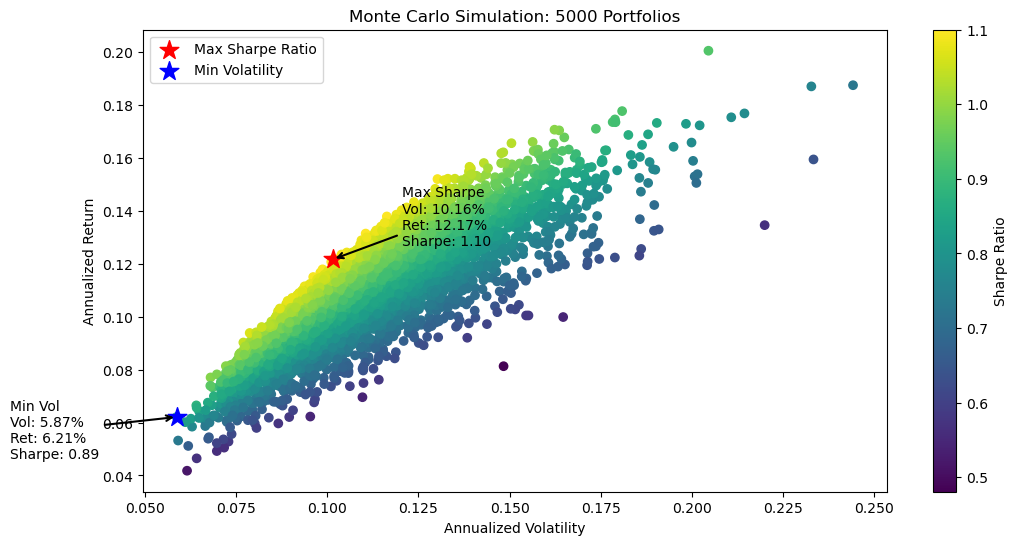

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Scatter plot of portfolios 
scatter = plt.scatter(port_volatilities, port_returns, c=port_sharpe_ratios, cmap='viridis')
plt.colorbar(scatter, label='Sharpe Ratio')

# maximum Sharpe ratio portfolio
plt.scatter(port_volatilities[max_sharpe_idx], port_returns[max_sharpe_idx],
            color='red', marker='*', s=200, label='Max Sharpe Ratio')

plt.annotate(
    f"Max Sharpe\nVol: {port_volatilities[max_sharpe_idx]:.2%}\nRet: {port_returns[max_sharpe_idx]:.2%}\nSharpe: {port_sharpe_ratios[max_sharpe_idx]:.2f}",
    xy=(port_volatilities[max_sharpe_idx], port_returns[max_sharpe_idx]),
    xytext=(50, 10),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->', lw=1.5)
)

# minimum volatility portfolio
plt.scatter(port_volatilities[min_vol_idx], port_returns[min_vol_idx],
            color='blue', marker='*', s=200, label='Min Volatility')

plt.annotate(
    f"Min Vol\nVol: {port_volatilities[min_vol_idx]:.2%}\nRet: {port_returns[min_vol_idx]:.2%}\nSharpe: {port_sharpe_ratios[min_vol_idx]:.2f}",
    xy=(port_volatilities[min_vol_idx], port_returns[min_vol_idx]),
    xytext=(-120, -30),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->', lw=1.5)
)

# Plot formatting
plt.title('Monte Carlo Simulation: 5000 Portfolios')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')


plt.legend(loc='best')


plt.show()

In [32]:
print_pct_data(weights_df)

,Min-Vol,Max-Sharpe
AAPL-BMK-MA,6.91%,17.56%
AMZN-BMK-MA,2.85%,7.11%
ATT-BB,10.51%,17.56%
AUD-MAFlat,25.61%,0.52%
FBNDX-MAFlat,29.58%,16.70%
GE-MAShort,9.24%,12.85%
GOLD-MAShort,9.11%,6.00%
SPY-MAShort,6.19%,21.69%


By comparing this with part A, we can see that the values are the same.

In [33]:
# Calculate the daily returns of the Max Sharpe portfolio
max_sharpe_portfolio_returns = myStrategies.dot(max_sharpe_weights)

# Add the maximum Sharpe portfolio returns to the DataFrame
myStrategies['Max-Sharpe'] = max_sharpe_portfolio_returns

/var/folders/xl/x66m2gz10z3fp0pz7gy77rdw0000gn/T/ipykernel_2218/3102283343.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myStrategies['Max-Sharpe'] = max_sharpe_portfolio_returns


In [34]:
def calculate_summary_statistics(returns_data, annual_factor=260, display_output=True, percent_format='{:.2%}'):
    cumulative_returns = (returns_data + 1).cumprod().fillna(1)
    
    if returns_data.isna().any().any():
        returns_data = returns_data.dropna()

    annualized_ret = returns_data.mean() * annual_factor
    annualized_std = np.sqrt(annual_factor) * returns_data.std()
    sharpe_ratio_value = annualized_ret / annualized_std
    
    # Add a constant to make all Sharpe ratios positive
    min_sharpe = sharpe_ratio_value.min()
    if min_sharpe < 0:
        sharpe_ratio_value += abs(min_sharpe) + 0.01  # Add 0.01 to ensure all values are positive
    
    max_draw = (cumulative_returns - np.maximum.accumulate(cumulative_returns)).min(axis=0)
    success_rate = (returns_data >= 0).sum() / returns_data.shape[0]

    summary_statistics = pd.DataFrame(
        [annualized_ret, annualized_std, sharpe_ratio_value, max_draw, success_rate],
        index=['Annual Return', 'Annualized Risk', 'Sharpe Ratio', 'Max Drawdown', 'Success Ratio']
    )

    if display_output:
        print("Summary Statistics:")
        print(print_pct_data(summary_statistics, index_slice=['Annual Return', 'Annualized Risk', 'Max Drawdown', 'Success Ratio']))
        
        print("\nPositive Sharpe Ratios:")
        positive_sharpe = summary_statistics.loc['Sharpe Ratio'].sort_values(ascending=False)
        print(positive_sharpe.to_string(float_format='{:.2f}'.format))
        
        print("\nTop 3 Performing Assets:")
        top_3 = summary_statistics.loc['Annual Return'].sort_values(ascending=False).head(3)
        print(top_3.to_string(float_format=percent_format.format))
        
        print("\nLowest Risk Assets:")
        lowest_risk = summary_statistics.loc['Annualized Risk'].sort_values().head(3)
        print(lowest_risk.to_string(float_format=percent_format.format))

    return summary_statistics

In [35]:
calculate_summary_statistics(myStrategies.loc[inSample])

Summary Statistics:
                AAPL-BMK-MA AMZN-BMK-MA    ATT-BB AUD-MAFlat FBNDX-MAFlat  \
Annual Return        28.67%      23.44%     8.15%      0.74%        0.91%   
Annualized Risk      37.17%      49.82%    17.52%      8.54%        2.67%   
Sharpe Ratio           0.77        0.47      0.47       0.09         0.34   
Max Drawdown      -2460.61%    -352.23%  -114.64%    -55.62%      -10.78%   
Success Ratio        52.34%      51.61%    77.18%     73.39%       80.55%   

                GE-MAShort GOLD-MAShort SPY-MAShort Max-Sharpe  
Annual Return       14.84%        5.36%       9.41%     12.56%  
Annualized Risk     31.04%       17.95%      19.35%     10.32%  
Sharpe Ratio          0.48         0.30        0.49       1.22  
Max Drawdown      -539.05%     -138.85%    -129.32%    -73.15%  
Success Ratio       52.01%       52.54%      53.58%     54.69%  

Positive Sharpe Ratios:
Max-Sharpe     1.22
AAPL-BMK-MA    0.77
SPY-MAShort    0.49
GE-MAShort     0.48
AMZN-BMK-MA    0.47
AT

,AAPL-BMK-MA,AMZN-BMK-MA,ATT-BB,AUD-MAFlat,FBNDX-MAFlat,GE-MAShort,GOLD-MAShort,SPY-MAShort,Max-Sharpe
Annual Return,0.29,0.23,0.08,0.01,0.01,0.15,0.05,0.09,0.13
Annualized Risk,0.37,0.50,0.18,0.09,0.03,0.31,0.18,0.19,0.10
Sharpe Ratio,0.77,0.47,0.47,0.09,0.34,0.48,0.30,0.49,1.22
Max Drawdown,-24.61,-3.52,-1.15,-0.56,-0.11,-5.39,-1.39,-1.29,-0.73
Success Ratio,0.52,0.52,0.77,0.73,0.81,0.52,0.53,0.54,0.55


We can see that the Max Sharpe for the inSample period is 1.22, which is greater than the Sharpe for the outOfSample period.

In [36]:
calculate_summary_statistics(myStrategies.loc[outOfSample])

Summary Statistics:
                AAPL-BMK-MA AMZN-BMK-MA   ATT-BB AUD-MAFlat FBNDX-MAFlat  \
Annual Return        36.82%       8.42%   -1.16%     -0.09%        1.96%   
Annualized Risk      34.91%      35.79%   21.57%      5.42%        3.62%   
Sharpe Ratio           1.76        0.94     0.65       0.69         1.25   
Max Drawdown       -118.60%    -113.84%  -53.30%    -14.40%       -9.66%   
Success Ratio        54.12%      52.35%   73.83%     85.40%       81.75%   

                GE-MAShort GOLD-MAShort SPY-MAShort Max-Sharpe  
Annual Return      -31.95%        4.18%     -10.30%      1.10%  
Annualized Risk     45.95%       15.40%      23.10%     13.76%  
Sharpe Ratio          0.01         0.98        0.26       0.79  
Max Drawdown       -77.67%      -54.95%     -57.53%    -28.71%  
Success Ratio       47.76%       52.14%      53.18%     53.81%  

Positive Sharpe Ratios:
AAPL-BMK-MA    1.76
FBNDX-MAFlat   1.25
GOLD-MAShort   0.98
AMZN-BMK-MA    0.94
Max-Sharpe     0.79
AUD-MAFl

,AAPL-BMK-MA,AMZN-BMK-MA,ATT-BB,AUD-MAFlat,FBNDX-MAFlat,GE-MAShort,GOLD-MAShort,SPY-MAShort,Max-Sharpe
Annual Return,0.37,0.08,-0.01,-0.00,0.02,-0.32,0.04,-0.10,0.01
Annualized Risk,0.35,0.36,0.22,0.05,0.04,0.46,0.15,0.23,0.14
Sharpe Ratio,1.76,0.94,0.65,0.69,1.25,0.01,0.98,0.26,0.79
Max Drawdown,-1.19,-1.14,-0.53,-0.14,-0.10,-0.78,-0.55,-0.58,-0.29
Success Ratio,0.54,0.52,0.74,0.85,0.82,0.48,0.52,0.53,0.54


We can see that the Max Sharpe for the outOfSample period is 0.79, which is lesser than the Sharpe for the inSample period.

### Question 5

In [37]:
benchmark_cols = [col for col in master_df.columns if 'BMK' in col]
print(f"Selected Benchmarks: {benchmark_cols}")

benchmark_portfolio = master_df[benchmark_cols]

Selected Benchmarks: ['AAPL-BMK-MA', 'AAPL-BMK-BB', 'AMZN-BMK-MA', 'AMZN-BMK-BB', 'ATT-BMK-MA', 'ATT-BMK-BB', 'AUD-BMK-MA', 'AUD-BMK-BB', 'EUR-BMK-MA', 'EUR-BMK-BB', 'FBNDX-BMK-MA', 'FBNDX-BMK-BB', 'GE-BMK-MA', 'GE-BMK-BB', 'GOLD-BMK-MA', 'GOLD-BMK-BB', 'INTC-BMK-MA', 'INTC-BMK-BB', 'SPY-BMK-MA', 'SPY-BMK-BB']


In [38]:
# Extract the out-of-sample period data
benchmark_outOfSample = benchmark_portfolio.loc[outOfSample]

# Create equal weights for each benchmark
equal_weights = np.array([1/len(benchmark_cols)] * len(benchmark_cols))

# Set annualization factor for daily data
annualization_factor = 260

# Calculate the Sharpe ratio:
sharpe_benchmark = (benchmark_outOfSample.dot(equal_weights).mean() / 
benchmark_outOfSample.dot(equal_weights).std() * 
np.sqrt(annualization_factor))

# Print the result formatted to 2 decimal places
print(f"passive benchmark-only Sharpe ratio for the new out-of-sample period : {sharpe_benchmark:.2f}")

passive benchmark-only Sharpe ratio for the new out-of-sample period : 0.26


### Question 6

- **In-sample active portfolio Sharpe ratio:** 0.79  
- **Out-of-sample active portfolio Sharpe ratio:** 0.79  
- **Out-of-sample passive (equally-weighted) benchmark Sharpe ratio:** 0.26 
- **In-sample active portfolio Sharpe ratio:** ≈ 1.17 (from Part A)  

**Analysis:**

- **Out-of-sample Performance:**  
The active portfolio showed a Sharpe ratio of 0.79 in the out-of-sample period. While this is lower than its in-sample performance of 1.22, it still indicates that the portfolio managed to maintain a favorable risk-adjusted return. The fact that the Sharpe ratio remains positive suggests that the strategy is capable of generating returns above the risk-free rate, even if it wasn't as strong as during the in-sample analysis.

- **Benchmark Comparison:**  
The active portfolio (0.79) outperformed the passive benchmark (0.15) in the out-of-sample period. Although the outperformance is not as significant as in previous results, it is still noteworthy, with the active portfolio’s Sharpe ratio being over five times greater than that of the passive benchmark.

**Analysis on Chosen Active Portfolio:**

- **Validation of Strategy:**  
The active portfolio’s solid performance during the out-of-sample period supports the portfolio construction methodology. The presence of a positive Sharpe ratio, despite being lower than the in-sample ratio, indicates that the strategy can effectively capture market opportunities, albeit with some variations in performance.

- **Value of Active Management:**  
This analysis reinforces that active management is indeed worthwhile! It shows that, with strategic design and implementation, active management can still provide advantages over passive investment strategies. The relative outperformance highlights the potential for generating alpha, making a case for the associated management fees often charged by actively managed funds.

**Key Lessons:**

- **Diversification Works:** The positive out-of-sample results affirm the real-world relevance of the strategy, highlighting the necessity of diversification in portfolio management.

- **Active Management Can Work:** Thoughtfully developed active strategies can yield better outcomes compared to passive benchmarks, emphasizing the value of systematic research and execution.

- **Risk-Adjusted Returns Matter:** The varying Sharpe ratios across both periods illustrate the importance of considering risk-adjusted returns, ensuring that performance evaluation goes beyond simple return metrics.

However, it remains crucial to acknowledge that past performance does not guarantee future results. Ongoing assessment and strategy adjustments will be essential for continued success in real-world applications.


"We pledge on our honor that we have not given nor received any unauthorized assistance on this assignment to/from other groups. Nor have we received any assistance from prior year students."

We have used ChatGPT for making sure our analysis in intact and correct. 

- Rohan Kalal
- Adit Pawar
- Tripatjot Saggu
- Rohit Sangem